In [1]:
# Imports and Dependencies 
import pandas as pd
import numpy as np

import nltk as nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
nltk.download('vader_lexicon')

import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/revph/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read in The Office CSV
the_office_df = pd.read_csv("Resources/the_office_series.csv")

In [3]:
# Tokenize the About column (episode description) for each episode title
# Define Lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english')) 

# Import word cloud dependencies 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [25.0, 10.0]

# Define function to clean text
def tokenizer(text):
    """Tokenizes text."""
    
    # Convert the words to lowercase
    regex = re.compile("[^a-zA-Z ]")
    
    # Remove the punctuation from text
    re_clean = regex.sub('', text)

    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
       
    # Remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    
    return tokens


Bad key "text.kerning_factor" on line 4 in
/Users/revph/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


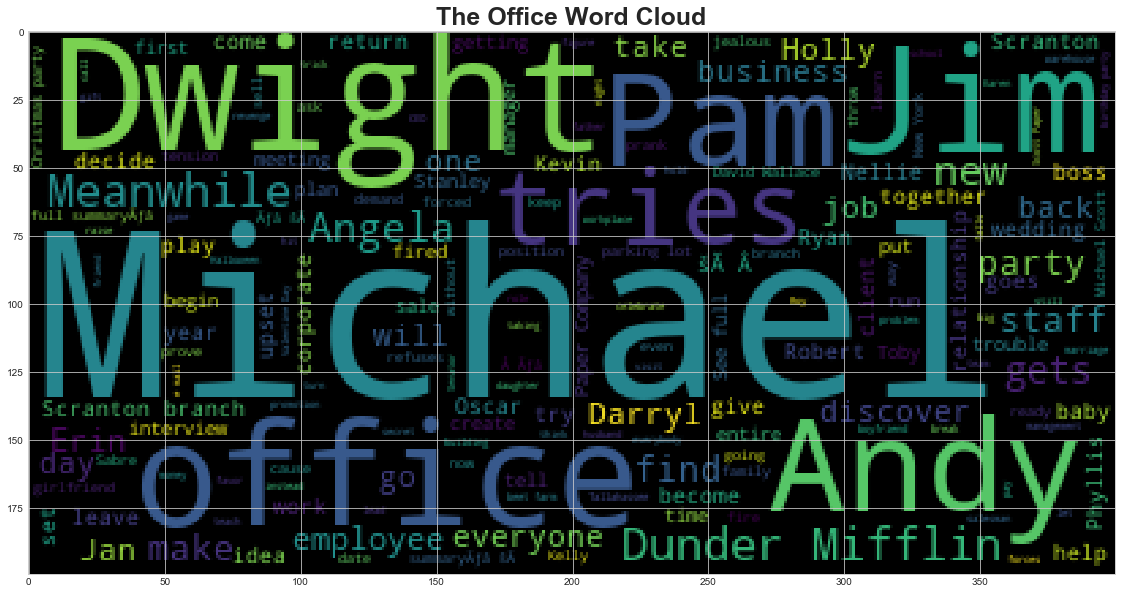

In [4]:
# Tokenize and Create Word Cloud
the_office_df['tokens'] = the_office_df['About'].apply(tokenizer)
office_string = ' '.join(the_office_df.About)

wc = WordCloud().generate(office_string)
plt.title('The Office Word Cloud',fontsize=25, fontweight='bold')
plt.imshow(wc)

In [5]:
# Define stemmer
stemmer = PorterStemmer()
# Create list to store tokenized summary descriptions
summary = []

# Iterate over the summary data while cleaning the text, append to summary list
for i in range(0,len(the_office_df)):
    about = re.sub('[^a-zA-Z]', ' ', the_office_df['About'][i])
    about = about.lower()
    about = about.split()
    about = [stemmer.stem(word) for word in about if not word in sw]
    about = ' '.join(about)
    summary.append(about)

In [6]:
# vectorizing and transforming summary descrptions such that we able to create a frequency classifying each word
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(summary)
words_list = vectorizer.get_feature_names()

In [7]:
# Getting the TF-IDF weight of each word in summary (episode descripition) as DataFrame
tfidf_scores_df = pd.DataFrame(
    list(zip(words_list, np.ravel(X.mean(axis=0)))), columns=["Word", "TF-IDF"]
)
tfidf_scores_df = tfidf_scores_df.sort_values(by=["TF-IDF"], ascending=False)
tfidf_scores_50 = tfidf_scores_df.nlargest(50, "TF-IDF")
tfidf_scores_50.reset_index(inplace=True)
tfidf_scores_50.head(10)

,index,Word,TF-IDF
0,604,michael,0.824468
1,310,dwight,0.526596
2,517,jim,0.473404
3,650,offic,0.430851
4,31,andi,0.372340
5,670,pam,0.367021
6,971,tri,0.308511
7,306,dunder,0.234043
8,608,mifflin,0.234043
9,591,meanwhil,0.228723


In [8]:
# Top 50 episodes sorted by Ratings
top_50_episodes = the_office_df.nlargest(50, "Ratings")
top_50_episodes.reset_index(inplace=True)

In [9]:
top_50_episodes.drop(["index", "Unnamed: 0", "Season", "Duration", "Date", "GuestStars", "Director", "Writers", "tokens"], axis=1, inplace=True)
top_50_episodes.head(10)

,EpisodeTitle,About,Ratings,Votes,Viewership
0,"Goodbye, Michael",As the office gets ready for Michael's final d...,9.8,8059,8.42
1,Finale,"One year later, Dunder Mifflin employees past ...",9.8,10515,5.69
2,Stress Relief,Dwight's too-realistic fire alarm gives Stanle...,9.7,8170,22.91
3,Dinner Party,Michael invites Jim and Pam and Andy and Angel...,9.5,5601,9.22
4,A.A.R.M.,Dwight prepares for a marriage proposal and hi...,9.5,3914,4.56
5,Casino Night,The Dunder Mifflin crew holds a casino party a...,9.4,4765,7.60
6,Niagara: Part 1,The Office travels to Niagara Falls to celebra...,9.4,4560,9.42
7,Niagara: Part 2,Pam is forced to deal with an embarrassing inj...,9.4,3114,9.42
8,Threat Level Midnight,"Michael finally finishes his movie ""Threat Lev...",9.4,4877,6.41
9,The Job,"Michael appoints Dwight as regional manager, a...",9.3,3898,7.88


In [10]:
# locate if a top 5 word appeared in the about summary and if so add binary value to data frame
top_50_episodes.loc[top_50_episodes['About'].str.contains("Michael"),'Michael'] = 1
top_50_episodes.loc[top_50_episodes['About'].str.contains("Dwight"),'Dwight'] = 1
top_50_episodes.loc[top_50_episodes['About'].str.contains("Jim"),'Jim'] = 1
top_50_episodes.loc[top_50_episodes['About'].str.contains("Office"),'Office'] = 1
top_50_episodes.loc[top_50_episodes['About'].str.contains("Andy"),'Andy'] = 1

top_50_episodes = top_50_episodes.replace(np.nan, 0)
top_50_episodes.set_index("EpisodeTitle", inplace=True)
top_50_episodes.head(10)

,About,Ratings,Votes,Viewership,Michael,Dwight,Jim,Office,Andy
EpisodeTitle,,,,,,,,,
"Goodbye, Michael",As the office gets ready for Michael's final d...,9.8,8059,8.42,1.0,0.0,0.0,0.0,1.0
Finale,"One year later, Dunder Mifflin employees past ...",9.8,10515,5.69,0.0,1.0,0.0,0.0,0.0
Stress Relief,Dwight's too-realistic fire alarm gives Stanle...,9.7,8170,22.91,1.0,1.0,0.0,0.0,0.0
Dinner Party,Michael invites Jim and Pam and Andy and Angel...,9.5,5601,9.22,1.0,1.0,1.0,0.0,1.0
A.A.R.M.,Dwight prepares for a marriage proposal and hi...,9.5,3914,4.56,0.0,1.0,1.0,0.0,1.0
Casino Night,The Dunder Mifflin crew holds a casino party a...,9.4,4765,7.60,1.0,0.0,0.0,0.0,0.0
Niagara: Part 1,The Office travels to Niagara Falls to celebra...,9.4,4560,9.42,1.0,1.0,1.0,1.0,1.0
Niagara: Part 2,Pam is forced to deal with an embarrassing inj...,9.4,3114,9.42,0.0,0.0,0.0,0.0,1.0
Threat Level Midnight,"Michael finally finishes his movie ""Threat Lev...",9.4,4877,6.41,1.0,0.0,0.0,0.0,0.0


In [11]:
# Define Target and Features
y = top_50_episodes['Ratings'].values
X = top_50_episodes.iloc[:,-7:]

In [12]:
from sklearn.model_selection import train_test_split

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=48)

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define Random Forest Model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 48)
  
# fit the regressor with x and y data
rf.fit(X, y)  

RandomForestRegressor(n_estimators=1000, random_state=48)

In [14]:
# predict ratings using test data
predicted = rf.predict(X_test)

In [15]:
# Create ratings data frame
ratings = pd.DataFrame({
    "Real Ratings": y_test.ravel(),
    "Predicted Ratings": predicted.ravel()
})
ratings

,Real Ratings,Predicted Ratings
0,9.4,9.3817
1,9.5,9.4187
2,8.7,8.8109
3,9.8,9.7287
4,8.6,8.6652
5,9.4,9.1796
6,9.3,9.2698
7,9.1,9.0615
8,9.0,8.9655
9,9.0,8.9860


In [16]:
# Calculate root mean squared error
from sklearn.metrics import r2_score,mean_squared_error

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
rmse

0.0815140667426617

In [17]:
# Define Target and Features
X = top_50_episodes.iloc[:,-5:]
y = top_50_episodes['Ratings'].values

# Split data into train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=48)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 48)
  
# fit the regressor with x and y data
rf.fit(X, y)  

# predict ratings using test data
predicted = rf.predict(X_test)

# Create ratings data frame
ratings = pd.DataFrame({
    "Real Ratings": y_test.ravel(),
    "Predicted Ratings": predicted.ravel()
})
ratings

,Real Ratings,Predicted Ratings
0,9.4,8.933579
1,9.5,8.989499
2,8.7,8.906315
3,9.8,9.264337
4,8.6,8.933579
5,9.4,9.384979
6,9.3,8.954560
7,9.1,9.039015
8,9.0,9.211456
9,9.0,8.933579


In [18]:
# Calculate root mean squared error
from sklearn.metrics import r2_score,mean_squared_error

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
rmse

0.3195251724966527

In [19]:
# Ranking the office by episode ratings 
the_office_ranked = the_office_df.sort_values(by="Ratings", ascending=False)

# vectorizing and transforming summary descrptions such that we able to create a frequency classifying each word
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(summary)
words_list = vectorizer.get_feature_names()

# Using cosine similarity to find the similarity between each episode based on their descriptions
cos_sim = cosine_similarity(X, X)
cos_sim.shape

# Create cosine similarity of the top Office episodes
cos_sim_df = pd.DataFrame(data=cos_sim,columns=the_office_ranked.EpisodeTitle)
cos_sim_df.head(10)

EpisodeTitle,Finale,"Goodbye, Michael",Stress Relief,A.A.R.M.,Dinner Party,Casino Night,Threat Level Midnight,Niagara: Part 2,Niagara: Part 1,Garage Sale,...,Lotto,Couples Discount,Roy's Wedding,Welcome Party,Fundraiser,Here Comes Treble,Angry Andy,Gettysburg,The Banker,Get the Girl
0,1.000000,0.000000,0.080064,0.000000,0.087706,0.087706,0.092450,0.000000,0.074125,0.104828,...,0.000000,0.000000,0.063628,0.000000,0.166410,0.000000,0.134535,0.113228,0.056614,0.214834
1,0.000000,1.000000,0.166667,0.000000,0.182574,0.273861,0.192450,0.102062,0.231455,0.000000,...,0.000000,0.083333,0.132453,0.000000,0.057735,0.000000,0.000000,0.000000,0.000000,0.074536
2,0.080064,0.166667,1.000000,0.102062,0.182574,0.182574,0.192450,0.000000,0.308607,0.109109,...,0.000000,0.083333,0.132453,0.096225,0.057735,0.066227,0.000000,0.117851,0.117851,0.074536
3,0.000000,0.000000,0.102062,1.000000,0.000000,0.000000,0.000000,0.000000,0.188982,0.000000,...,0.094491,0.102062,0.081111,0.117851,0.141421,0.162221,0.085749,0.144338,0.144338,0.091287
4,0.087706,0.182574,0.182574,0.000000,1.000000,0.200000,0.210819,0.000000,0.253546,0.119523,...,0.084515,0.000000,0.072548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.087706,0.273861,0.182574,0.000000,0.200000,1.000000,0.210819,0.111803,0.253546,0.119523,...,0.000000,0.091287,0.072548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.092450,0.192450,0.192450,0.000000,0.210819,0.210819,1.000000,0.000000,0.178174,0.125988,...,0.000000,0.000000,0.076472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086066
7,0.000000,0.102062,0.000000,0.000000,0.000000,0.111803,0.000000,1.000000,0.094491,0.000000,...,0.000000,0.102062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.074125,0.231455,0.308607,0.188982,0.253546,0.253546,0.178174,0.094491,1.000000,0.101015,...,0.071429,0.154303,0.122628,0.089087,0.106904,0.122628,0.064820,0.163663,0.109109,0.069007
9,0.104828,0.000000,0.109109,0.000000,0.119523,0.119523,0.125988,0.000000,0.101015,1.000000,...,0.000000,0.000000,0.086711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# locate where Michael and Dwight appear in the episode summary and add binary value to data frame
the_office_ranked.loc[the_office_ranked['About'].str.contains("Michael"),'Michael'] = 1
the_office_ranked.loc[the_office_ranked['About'].str.contains("Dwight"),'Dwight'] = 1

the_office_ranked = the_office_ranked.replace(np.nan, 0)

df = the_office_ranked[["EpisodeTitle", "About", "Michael", "Dwight"]]
df['Episode_Num'] = np.arange(0,188)


# Function create to see the similarity between episodes based on whether or not both Michael and Dwight appeared in the 
# episode description
def episode_recommendation(episode_name):
    for i in range(0,50):
        if (df.values[i][2] == 1) and (df.values[i][3] == 1):
            episode_index = df.values[i][4]
            epidode_name = df.values[i][0]
            sorted_data = cos_sim_df.iloc[episode_index].sort_values(ascending=False)
            sorted_df = pd.DataFrame(sorted_data)
            print(epidode_name, sorted_df.iloc[1:4])
            print("-"*75)

<ipython-input-20-d05a61ac8deb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Episode_Num'] = np.arange(0,188)


In [21]:
# call function where episode description contains both Michael and Dwight 
episode_recommendation(1)

Stress Relief                                 2
EpisodeTitle                     
Dunder Mifflin Infinity  0.314970
The Job                  0.308607
Niagara: Part 1          0.308607
---------------------------------------------------------------------------
Dinner Party                                        4
EpisodeTitle                            
Weight Loss                     0.316228
Michael's Last Dundies          0.286039
Take Your Daughter to Work Day  0.258199
---------------------------------------------------------------------------
Niagara: Part 1                      8
EpisodeTitle          
The Job       0.500000
Beach Games   0.429198
Fun Run       0.390095
---------------------------------------------------------------------------
The Job                        11
EpisodeTitle             
Niagara: Part 1  0.500000
Business Ethics  0.412514
Golden Ticket    0.406579
---------------------------------------------------------------------------
The Injury               

In [22]:
top_50_episodes.loc[["Stress Relief"]]["Ratings"]

EpisodeTitle
Stress Relief    9.7
Name: Ratings, dtype: float64

In [23]:
the_office_df.loc[the_office_df["EpisodeTitle"]=="Dunder Mifflin Infinity"]["Ratings"]

52    8.3
Name: Ratings, dtype: float64